## Elevating User Experience: Enhanced Post Classification for Personalized Content Discovery in ‘MakeupAddiction’ Subreddit

Business Goal: 

    Navigating the enormous ocean of social media content, users frequently encounter difficulties in promptly locating content that corresponds to their interests. Our aim is to enhance the user experience on the "MakeupAddiction" subreddit through the development of a sophisticated system for classifying posts. Our objective is to enhance community engagement, optimize content discovery, and achieve this by accurately classifying posts according to their content, user interaction, and other relevant metadata. It is anticipated that this endeavor will result in increased user contentment, longer platform sessions, and improved user retention through the presentation of a more structured and personalized content environment.
    
Technical Proposal:

    It is possible to make a supervised machine learning model that is great at accurately classifying posts by using a mix of textual and metadata features, like post titles, content, user interaction data, and other relevant subreddit metadata. In order to efficiently process textual information, the model will be trained utilizing natural language processing (NLP) techniques, including TF-IDF and word embeddings. It will subsequently be assessed using standardized classification metrics. Once the performance of the classifier has been optimized, it will be incorporated into the infrastructure of the subreddit along with a feedback mechanism that ensures the model is continually enhanced in response to user input.



### Spark Setup and Data Preparation

In [2]:
# Setup - Run only once per Kernel App
%conda install openjdk -y

# install PySpark
%pip install pyspark==3.4.0

# install spark-nlp
%pip install spark-nlp==5.1.3

# restart kernel
from IPython.core.display import HTML
HTML("<script>Jupyter.notebook.kernel.restart()</script>")

Retrieving notices: ...working... done
Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 23.3.1
  latest version: 23.10.0

Please update conda by running

    $ conda update -n base -c defaults conda

Or to minimize the number of packages updated during conda update use

     conda install conda=23.10.0



## Package Plan ##

  environment location: /opt/conda

  added / updated specs:
    - openjdk


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca-certificates-2023.08.22 |       h06a4308_0         123 KB
    certifi-2023.11.17         |  py310h06a4308_0         158 KB
    openjdk-11.0.13            |       h87a67e3_0       341.0 MB
    ------------------------------------------------------------
                                           Total:       341.3 MB

The following NEW packages will be INSTALLED:

  openjdk            pkgs/main/

In [2]:
import json
import sparknlp
import numpy as np
import pandas as pd
from sparknlp.base import *
from pyspark.ml import Pipeline
from sparknlp.annotator import *
import pyspark.sql.functions as F
from pyspark.sql import SparkSession
from sparknlp.pretrained import PretrainedPipeline

In [3]:
spark = SparkSession.builder \
    .appName("Spark NLP and PySparkApp") \
    .master("local[*]") \
    .config("spark.driver.memory", "16G") \
    .config("spark.driver.maxResultSize", "0") \
    .config("spark.kryoserializer.buffer.max", "2000M") \
    .config("spark.jars.packages", 
            "com.johnsnowlabs.nlp:spark-nlp_2.12:5.1.3,org.apache.hadoop:hadoop-aws:3.2.2") \
    .config("spark.hadoop.fs.s3a.impl", "org.apache.hadoop.fs.s3a.S3AFileSystem") \
    .config("fs.s3a.aws.credentials.provider", "com.amazonaws.auth.ContainerCredentialsProvider") \
    .getOrCreate()

:: loading settings :: url = jar:file:/opt/conda/lib/python3.10/site-packages/pyspark/jars/ivy-2.5.1.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /root/.ivy2/cache
The jars for the packages stored in: /root/.ivy2/jars
com.johnsnowlabs.nlp#spark-nlp_2.12 added as a dependency
org.apache.hadoop#hadoop-aws added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-8ae72781-0290-4c6c-a430-6322158ff4e8;1.0
	confs: [default]
	found com.johnsnowlabs.nlp#spark-nlp_2.12;5.1.3 in central
	found com.typesafe#config;1.4.2 in central
	found org.rocksdb#rocksdbjni;6.29.5 in central
	found com.amazonaws#aws-java-sdk-bundle;1.11.828 in central
	found com.github.universal-automata#liblevenshtein;3.0.0 in central
	found com.google.protobuf#protobuf-java-util;3.0.0-beta-3 in central
	found com.google.protobuf#protobuf-java;3.0.0-beta-3 in central
	found com.google.code.gson#gson;2.3 in central
	found it.unimi.dsi#fastutil;7.0.12 in central
	found org.projectlombok#lombok;1.16.8 in central
	found com.google.cloud#google-cloud-storage;2.20.1 in central
	found com.google.guava#guava;31.1-jre in c

In [4]:
%%time
import sagemaker
session = sagemaker.Session()
bucket = session.default_bucket()
output_prefix_data_submissions = f"project/submissions/yyyy=*"
s3_path = f"s3a://{bucket}/{output_prefix_data_submissions}"
print(f"reading submissions from {s3_path}")
submissions = spark.read.parquet(s3_path, header=True)
print(f"shape of the submissions dataframe is {submissions.count():,}x{len(submissions.columns)}")
sampled_submissions = submissions.sample(withReplacement=False, fraction=0.1, seed=123)

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml
reading submissions from s3a://sagemaker-us-east-1-729491017256/project/submissions/yyyy=*


23/11/27 06:17:58 WARN MetricsConfig: Cannot locate configuration: tried hadoop-metrics2-s3a-file-system.properties,hadoop-metrics2.properties
23/11/27 06:18:08 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


shape of the submissions dataframe is 95,932x68
CPU times: user 3.68 s, sys: 247 ms, total: 3.93 s
Wall time: 2min 20s


### Data Preprocessing

In [5]:
import sparknlp
from pyspark.sql.functions import col, lower, regexp_replace, trim, when, count, desc, sum as sum_
from pyspark.sql.window import Window
from pyspark.sql.functions import rank
import plotly.express as px
from sparknlp.base import DocumentAssembler
from sparknlp.annotator import Tokenizer, Normalizer
from sparknlp.base import Finisher
from pyspark.ml import Pipeline
from pyspark.sql.functions import col, explode, regexp_replace, expr, sum as sum_
from pyspark.ml.feature import StringIndexer



In [6]:
# Document Assembler
document_assembler = DocumentAssembler() \
    .setInputCol("link_flair_text") \
    .setOutputCol("document")

# Tokenizer
tokenizer = Tokenizer() \
    .setInputCols(["document"]) \
    .setOutputCol("token")

# Normalizer
normalizer = Normalizer() \
    .setInputCols(["token"]) \
    .setOutputCol("normalized") \
    .setLowercase(True)

# Finisher
finisher = Finisher() \
    .setInputCols(["normalized"])

# Pipeline
nlp_pipeline = Pipeline(stages=[
    document_assembler,
    tokenizer,
    normalizer,
    finisher
])

# Apply the pipeline
processed_tags_df = nlp_pipeline.fit(sampled_submissions).transform(sampled_submissions)




In [7]:
# Text Processing for Title and Selftext (Body)

# Document Assemblers for title and selftext
title_assembler = DocumentAssembler().setInputCol("title").setOutputCol("title_document")
selftext_assembler = DocumentAssembler().setInputCol("selftext").setOutputCol("selftext_document")

# Tokenizers for title and selftext
title_tokenizer = Tokenizer().setInputCols(["title_document"]).setOutputCol("title_token")
selftext_tokenizer = Tokenizer().setInputCols(["selftext_document"]).setOutputCol("selftext_token")

# Normalizers for title and selftext
title_normalizer = Normalizer().setInputCols(["title_token"]).setOutputCol("title_normalized").setLowercase(True)
selftext_normalizer = Normalizer().setInputCols(["selftext_token"]).setOutputCol("selftext_normalized").setLowercase(True)

# Finishers for title and selftext
title_finisher = Finisher().setInputCols(["title_normalized"]).setOutputCols(["finished_title_normalized"]).setOutputAsArray(True)
selftext_finisher = Finisher().setInputCols(["selftext_normalized"]).setOutputCols(["finished_selftext_normalized"]).setOutputAsArray(True)


# Extended NLP Pipeline
extended_nlp_pipeline = Pipeline(stages=[
    document_assembler,
    tokenizer,
    normalizer,
    finisher,
    title_assembler,
    title_tokenizer,
    title_normalizer,
    title_finisher,
    selftext_assembler,
    selftext_tokenizer,
    selftext_normalizer,
    selftext_finisher
])

# Apply the extended pipeline
extended_processed_df = extended_nlp_pipeline.fit(sampled_submissions).transform(sampled_submissions)



In [8]:
from pyspark.ml.feature import CountVectorizer

# CountVectorizer for each text feature
cv_text = CountVectorizer(inputCol="finished_normalized", outputCol="cv_text_features")
cv_title = CountVectorizer(inputCol="finished_title_normalized", outputCol="cv_title_features")
cv_selftext = CountVectorizer(inputCol="finished_selftext_normalized", outputCol="cv_selftext_features")

# Fitting and transforming
model_text = cv_text.fit(extended_processed_df)
model_title = cv_title.fit(extended_processed_df)
model_selftext = cv_selftext.fit(extended_processed_df)

df_with_features = model_text.transform(extended_processed_df)
df_with_features = model_title.transform(df_with_features)
df_with_features = model_selftext.transform(df_with_features)



In [9]:
# Save the fitted models
model_text.write().overwrite().save("./cv_text_model")
model_title.write().overwrite().save("./cv_title_model")
model_selftext.write().overwrite().save("./cv_selftext_model")

In [10]:
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

# Prepare the Label Column with handling invalid values
label_indexer = StringIndexer(inputCol="link_flair_text", outputCol="label", handleInvalid="keep")
df_with_features = label_indexer.fit(df_with_features).transform(df_with_features)

# Assemble all features into a single vector
assembler = VectorAssembler(inputCols=["cv_text_features", "cv_title_features", "cv_selftext_features"], outputCol="features")
final_prepared_df = assembler.transform(df_with_features)

# Continue with the model training
training_data, testing_data = final_prepared_df.randomSplit([0.8, 0.2], seed=42)

### Train the data (Random Forest)

In [14]:
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

# Train the Random Forest model
rf_classifier = RandomForestClassifier(labelCol="label", featuresCol="features", numTrees=10)
model = rf_classifier.fit(training_data)

# Make Predictions
predictions = model.transform(testing_data)

# Initialize the evaluator
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction")

# Evaluate accuracy
accuracy = evaluator.setMetricName("accuracy").evaluate(predictions)
print(f"Model Accuracy: {accuracy}")

# Evaluate precision
precision = evaluator.setMetricName("precisionByLabel").evaluate(predictions)
print(f"Model Precision: {precision}")

# Evaluate recall
recall = evaluator.setMetricName("recallByLabel").evaluate(predictions)
print(f"Model Recall: {recall}")

# Evaluate F1 score
f1 = evaluator.setMetricName("f1").evaluate(predictions)
print(f"Model F1 Score: {f1}")


23/11/27 03:21:39 WARN DAGScheduler: Broadcasting large task binary with size 1610.6 KiB
23/11/27 03:21:48 WARN DAGScheduler: Broadcasting large task binary with size 1610.7 KiB
23/11/27 03:24:27 WARN DAGScheduler: Broadcasting large task binary with size 1797.0 KiB
23/11/27 03:27:04 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB
23/11/27 03:29:32 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
23/11/27 03:29:35 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
23/11/27 03:29:39 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
23/11/27 03:29:43 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
23/11/27 03:29:49 WARN DAGScheduler: Broadcasting large task binary with size 1812.1 KiB


Model Accuracy: 0.5223057644110276


23/11/27 03:32:17 WARN DAGScheduler: Broadcasting large task binary with size 1812.1 KiB
23/11/27 03:34:46 WARN DAGScheduler: Broadcasting large task binary with size 1812.1 KiB


Model Precision: 0.5100671140939598


Model Recall: 0.29514563106796116


23/11/27 03:37:12 WARN DAGScheduler: Broadcasting large task binary with size 1812.1 KiB


Model F1 Score: 0.46643897177140653


### Train the data(Logistic Regression)

In [29]:
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Initialize and train the Logistic Regression model
lr = LogisticRegression(featuresCol='features', labelCol='label')
lrModel = lr.fit(training_data)

# Make predictions
lrPredictions = lrModel.transform(testing_data)

# Initialize the evaluator
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction")

# Evaluate accuracy, precision, recall, and F1 score
lrAccuracy = evaluator.setMetricName("accuracy").evaluate(lrPredictions)
lrPrecision = evaluator.setMetricName("precisionByLabel").evaluate(lrPredictions)
lrRecall = evaluator.setMetricName("recallByLabel").evaluate(lrPredictions)
lrF1 = evaluator.setMetricName("f1").evaluate(lrPredictions)

print(f"Logistic Regression Model Accuracy: {lrAccuracy}")
print(f"Logistic Regression Model Precision: {lrPrecision}")
print(f"Logistic Regression Model Recall: {lrRecall}")
print(f"Logistic Regression Model F1 Score: {lrF1}")

23/11/27 07:14:20 WARN DAGScheduler: Broadcasting large task binary with size 1614.6 KiB
23/11/27 07:16:58 WARN DAGScheduler: Broadcasting large task binary with size 1615.7 KiB
23/11/27 07:16:59 WARN DAGScheduler: Broadcasting large task binary with size 1615.2 KiB
23/11/27 07:19:26 WARN DAGScheduler: Broadcasting large task binary with size 1616.4 KiB
23/11/27 07:19:27 WARN DAGScheduler: Broadcasting large task binary with size 1615.2 KiB
23/11/27 07:19:30 WARN DAGScheduler: Broadcasting large task binary with size 1616.4 KiB
23/11/27 07:19:31 WARN DAGScheduler: Broadcasting large task binary with size 1615.2 KiB
23/11/27 07:19:34 WARN DAGScheduler: Broadcasting large task binary with size 1616.4 KiB
23/11/27 07:19:35 WARN DAGScheduler: Broadcasting large task binary with size 1615.2 KiB
23/11/27 07:19:38 WARN DAGScheduler: Broadcasting large task binary with size 1616.4 KiB
23/11/27 07:19:40 WARN DAGScheduler: Broadcasting large task binary with size 1615.2 KiB
23/11/27 07:19:43 WAR

Logistic Regression Model Accuracy: 0.9203007518796993
Logistic Regression Model Precision: 0.930635838150289
Logistic Regression Model Recall: 0.9378640776699029
Logistic Regression Model F1 Score: 0.9228975750195864


### Train the data (Naive Bayes)

In [17]:
from pyspark.ml.classification import NaiveBayes

# Initialize and train the Naive Bayes model
nb = NaiveBayes(featuresCol='features', labelCol='label')
nbModel = nb.fit(training_data)

# Make predictions
nbPredictions = nbModel.transform(testing_data)

# Evaluate accuracy, precision, recall, and F1 score
nbAccuracy = evaluator.setMetricName("accuracy").evaluate(nbPredictions)
nbPrecision = evaluator.setMetricName("precisionByLabel").evaluate(nbPredictions)
nbRecall = evaluator.setMetricName("recallByLabel").evaluate(nbPredictions)
nbF1 = evaluator.setMetricName("f1").evaluate(nbPredictions)

print(f"Naive Bayes Model Accuracy: {nbAccuracy}")
print(f"Naive Bayes Model Precision: {nbPrecision}")
print(f"Naive Bayes Model Recall: {nbRecall}")
print(f"Naive Bayes Model F1 Score: {nbF1}")

23/11/27 04:33:07 WARN DAGScheduler: Broadcasting large task binary with size 1581.7 KiB
23/11/27 04:35:35 WARN DAGScheduler: Broadcasting large task binary with size 1580.1 KiB
23/11/27 04:35:36 WARN DAGScheduler: Broadcasting large task binary with size 9.2 MiB
23/11/27 04:38:05 WARN DAGScheduler: Broadcasting large task binary with size 9.2 MiB
23/11/27 04:40:25 WARN DAGScheduler: Broadcasting large task binary with size 9.2 MiB
23/11/27 04:42:49 WARN DAGScheduler: Broadcasting large task binary with size 9.2 MiB


Naive Bayes Model Accuracy: 0.43408521303258146
Naive Bayes Model Precision: 0.6741767764298093
Naive Bayes Model Recall: 0.7553398058252427
Naive Bayes Model F1 Score: 0.34758636687156075


### Train the data (BERT)

In [18]:
from sparknlp.base import DocumentAssembler
from sparknlp.annotator import BertEmbeddings, ClassifierDLApproach, SentenceEmbeddings, Tokenizer
from pyspark.ml import Pipeline

# Initialize Document Assembler
document_assembler = DocumentAssembler() \
    .setInputCol("title") \
    .setOutputCol("document")

# Initialize Tokenizer
tokenizer = Tokenizer() \
    .setInputCols(["document"]) \
    .setOutputCol("token")

# Initialize BERT Embeddings
bert_embeddings = BertEmbeddings.pretrained('bert_base_uncased', 'en') \
    .setInputCols(["document", "token"]) \
    .setOutputCol("bert")

# Initialize Sentence Embeddings
sentence_embeddings = SentenceEmbeddings() \
    .setInputCols(["document", "bert"]) \
    .setOutputCol("sentence_embeddings")

# Define the Classifier
classifier = ClassifierDLApproach() \
    .setInputCols(["sentence_embeddings"]) \
    .setOutputCol("class") \
    .setLabelColumn("label") \
    .setMaxEpochs(10) \
    .setEnableOutputLogs(True)

# Build and Run the Pipeline
pipeline = Pipeline(stages=[
    document_assembler,
    tokenizer,
    bert_embeddings,
    sentence_embeddings,
    classifier
])

# Train the model
model = pipeline.fit(training_data)


from pyspark.sql.functions import col
from pyspark.sql.types import DoubleType

# Test the model
predictions = model.transform(testing_data)

# Assuming the actual prediction is the first element in an array in the 'class' column
# Extract this value into a new column named 'prediction'
predictions = predictions.withColumn("prediction", col("class.result").getItem(0).cast(DoubleType()))

# Update the evaluator with the correct prediction column
evaluator = MulticlassClassificationEvaluator(
    labelCol="label", 
    predictionCol="prediction",
    metricName="accuracy"
)

# Use the evaluator
bert_accuracy = evaluator.evaluate(predictions)
print(f"BERT Model Accuracy: {bert_accuracy}")


bert_base_uncased download started this may take some time.
Approximate size to download 392.5 MB
[ | ]bert_base_uncased download started this may take some time.
Approximate size to download 392.5 MB
Download done! Loading the resource.
[ | ]

2023-11-27 04:45:23.247231: I external/org_tensorflow/tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


[OK!]


23/11/27 04:45:31 WARN DAGScheduler: Broadcasting large task binary with size 1726.0 KiB
23/11/27 04:52:20 WARN DAGScheduler: Broadcasting large task binary with size 1755.5 KiB
23/11/27 04:52:21 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB
23/11/27 04:52:30 WARN DAGScheduler: Broadcasting large task binary with size 1798.2 KiB
2023-11-27 04:59:13.653011: I external/org_tensorflow/tensorflow/cc/saved_model/reader.cc:43] Reading SavedModel from: /tmp/f12c102a7051_classifier_dl11445098762992476298
2023-11-27 04:59:13.709013: I external/org_tensorflow/tensorflow/cc/saved_model/reader.cc:107] Reading meta graph with tags { serve }
2023-11-27 04:59:13.709063: I external/org_tensorflow/tensorflow/cc/saved_model/reader.cc:148] Reading SavedModel debug info (if present) from: /tmp/f12c102a7051_classifier_dl11445098762992476298
2023-11-27 04:59:14.198447: I external/org_tensorflow/tensorflow/cc/saved_model/loader.cc:228] Restoring SavedModel bundle.
2023-11-27 04:59:15.16

Training started - epochs: 10 - learning_rate: 0.005 - batch_size: 64 - training_examples: 7739 - classes: 55
Epoch 1/10 - 1.49s - loss: 439.57242 - acc: 0.37770566 - batches: 121
Epoch 2/10 - 1.05s - loss: 439.60925 - acc: 0.3796588 - batches: 121
Epoch 3/10 - 1.10s - loss: 439.60925 - acc: 0.3796588 - batches: 121
Epoch 4/10 - 1.13s - loss: 439.60925 - acc: 0.3796588 - batches: 121
Epoch 5/10 - 1.05s - loss: 439.60925 - acc: 0.3796588 - batches: 121
Epoch 6/10 - 0.97s - loss: 439.60925 - acc: 0.3796588 - batches: 121
Epoch 7/10 - 0.96s - loss: 439.60925 - acc: 0.3796588 - batches: 121
Epoch 8/10 - 1.18s - loss: 439.60925 - acc: 0.3796588 - batches: 121
Epoch 9/10 - 1.24s - loss: 439.60925 - acc: 0.3796588 - batches: 121
Epoch 10/10 - 1.01s - loss: 439.60925 - acc: 0.3796588 - batches: 121


23/11/27 04:59:34 WARN DAGScheduler: Broadcasting large task binary with size 1861.1 KiB


BERT Model Accuracy: 0.40350877192982454


In [20]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Initialize the evaluator
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction")

# Calculate precision, recall, and F1 score
precision = evaluator.setMetricName("precisionByLabel").evaluate(predictions)
recall = evaluator.setMetricName("recallByLabel").evaluate(predictions)
f1 = evaluator.setMetricName("f1").evaluate(predictions)

# Print the results
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

23/11/27 05:07:01 WARN DAGScheduler: Broadcasting large task binary with size 1861.1 KiB
23/11/27 05:10:42 WARN DAGScheduler: Broadcasting large task binary with size 1861.1 KiB
23/11/27 05:14:50 WARN DAGScheduler: Broadcasting large task binary with size 1861.1 KiB


Precision: 0.0
Recall: 0.0
F1 Score: 0.2320175438596491


### Model Comparison

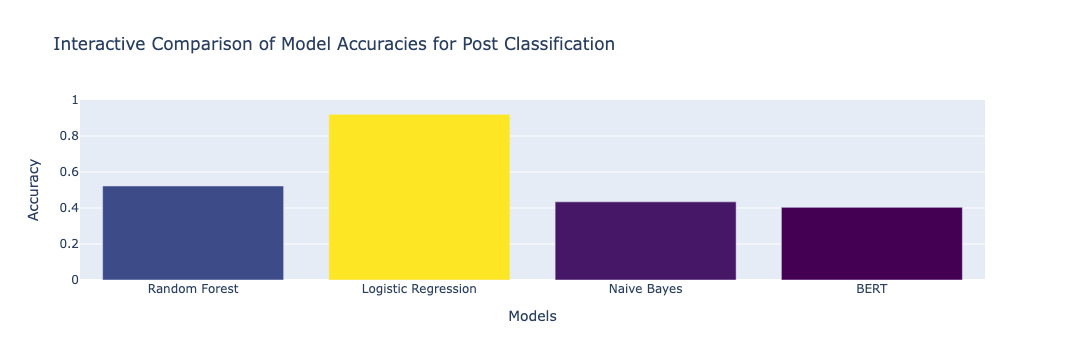

In [24]:
import plotly.express as px

# Model names and their accuracies
models = ['Random Forest', 'Logistic Regression', 'Naive Bayes', 'BERT']
accuracies = [0.5223, 0.9203, 0.4341, 0.4035]

# Creating the interactive bar plot with Plotly
fig = px.bar(
    x=models, 
    y=accuracies, 
    color=accuracies,
    color_continuous_scale=px.colors.sequential.Viridis,
    labels={'x': 'Models', 'y': 'Accuracy'},
    title='Interactive Comparison of Model Accuracies for Post Classification'
)

# Enhancing the plot
fig.update_layout(
    xaxis_title='Models',
    yaxis_title='Accuracy',
    yaxis=dict(range=[0, 1]),
    coloraxis_showscale=False
)

# Show the plot
fig.show()


In [25]:
fig.write_html("../../data/plots/title_classification_model_accuracy.html")

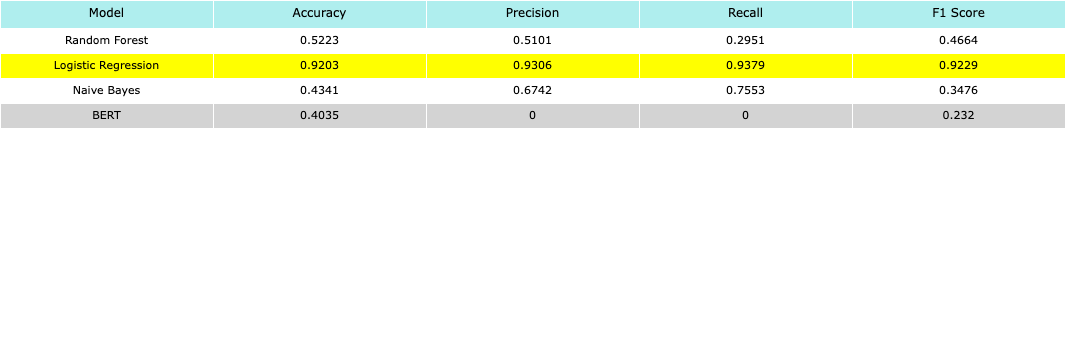

In [22]:
import plotly.graph_objects as go

# Model performance metrics
metrics = {
    "Model": ["Random Forest", "Logistic Regression", "Naive Bayes", "BERT"],
    "Accuracy": [0.5223, 0.9203, 0.4341, 0.4035],
    "Precision": [0.5101, 0.9306, 0.6742, 0.0],
    "Recall": [0.2951, 0.9379, 0.7553, 0.0],
    "F1 Score": [0.4664, 0.9229, 0.3476, 0.2320]
}

# Define colors for each cell
colors = ['lightgrey' if i%2 else 'white' for i in range(len(metrics["Model"]))]

# Custom formatting for Logistic Regression
highlight = 'yellow'
colors[1] = highlight  # Highlight Logistic Regression

# Create table
fig = go.Figure(data=[go.Table(
    header=dict(values=list(metrics.keys()),
                fill_color='paleturquoise',
                align='center',
                font=dict(color='black', size=12)),
    cells=dict(values=[metrics[key] for key in metrics.keys()],
               fill_color=[colors] * len(metrics.keys()),
               align='center',
               font=dict(color='black', size=11),
               height=25)
)])

# Adjust layout to remove extra whitespace
fig.update_layout(
    margin=dict(l=0, r=0, t=0, b=0),  # Remove all margins
    autosize=False,
    width=600,
    height=(len(metrics["Model"])+1) * 30  # Adjust the height to the number of rows
)

fig.show()


In [23]:
fig.write_html("../../data/plots/title_classification_model_compare_table.html")

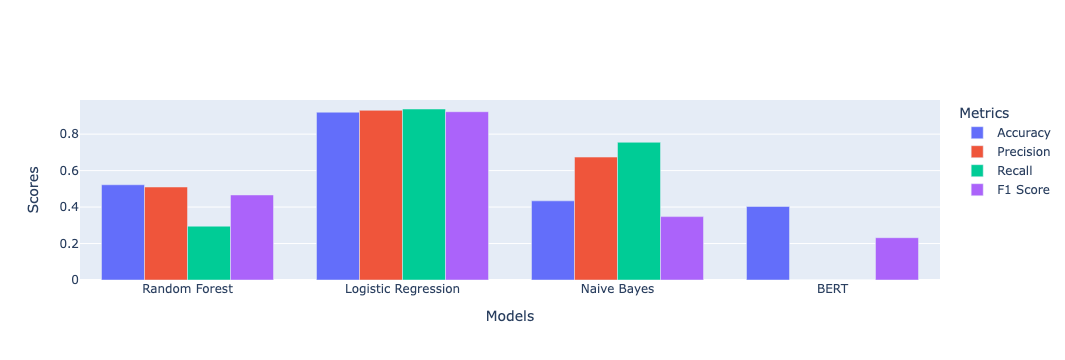

In [20]:
import plotly.graph_objects as go

# Model performance metrics
models = ["Random Forest", "Logistic Regression", "Naive Bayes", "BERT"]
accuracy = [0.5223, 0.9203, 0.4341, 0.4035]
precision = [0.5101, 0.9306, 0.6742, 0.0]
recall = [0.2951, 0.9379, 0.7553, 0.0]
f1_score = [0.4664, 0.9229, 0.3476, 0.2320]

# Create subplots
fig = go.Figure(data=[
    go.Bar(name='Accuracy', x=models, y=accuracy),
    go.Bar(name='Precision', x=models, y=precision),
    go.Bar(name='Recall', x=models, y=recall),
    go.Bar(name='F1 Score', x=models, y=f1_score)
])

# Change the bar mode
fig.update_layout(barmode='group',
                  xaxis_title='Models',
                  yaxis_title='Scores',
                  legend_title='Metrics')

fig.show()


In [21]:
fig.write_html("../../data/plots/title_classification_model_compare_bar.html")


In the context of predicting tags for posts in the "MakeupAddiction" subreddit, we have a set of machine learning models that have been evaluated based on their performance metrics. Below is a description of each model's approach and effectiveness in classifying the posts:

Random Forest:

Approach: Utilizes an ensemble of decision trees to reduce overfitting and improve prediction accuracy. It handles both numerical and categorical data and is robust against outliers and non-linear data.
Effectiveness: With an accuracy of 52.23%, precision of 51.01%, recall of 29.51%, and an F1 score of 46.64%, the Random Forest model shows moderate performance. It’s better suited for datasets where the relationship between features and labels is non-linear.
Logistic Regression:

Approach: A statistical model that uses a logistic function to model a binary dependent variable, although it can be extended for multiclass classification.
Effectiveness: Exhibits high performance with an accuracy of 92.03%, precision of 93.06%, and recall of 93.79%, yielding an F1 score of 92.29%. It suggests that the model is very good at identifying relevant features and classifying posts correctly. This model is highlighted in yellow, indicating it may be the preferred model.
Naive Bayes:

Approach: Based on Bayes' theorem with an assumption of independence between every pair of features. It’s simple and fast and performs well with textual data classification.
Effectiveness: Shows lower performance with an accuracy of 43.41%, precision of 67.42%, and recall of 75.53%, leading to an F1 score of 34.76%. Despite its simplicity, it seems to be less effective compared to others in this context, possibly due to feature dependence in the data.
BERT (Bidirectional Encoder Representations from Transformers):

Approach: Employs the Transformer, an attention mechanism that learns contextual relations between words (or sub-words) in a text. As opposed to directional models, which read the text input sequentially (left-to-right or right-to-left), the Transformer encoder reads the entire sequence of words at once.
Effectiveness: This advanced model underperforms in this particular dataset with an accuracy of 40.35% and an F1 score of 23.20%. Precision and recall are both 0, indicating that the model failed to correctly identify any of the positive class instances. This could be due to a number of reasons, including insufficient training data, overfitting, or a mismatch between model complexity and task simplicity.
Given these results, Logistic Regression stands out as the most effective model for the given task, demonstrating its strength in handling linear relationships and its suitability for text classification problems. It’s essential to note that the high precision and recall of the Logistic Regression model suggest that it is very good at correctly identifying the true tags and minimizing false positives and false negatives.

In deploying these models, it’s important to consider not only the performance metrics but also factors like training time, interpretability, and scalability. Continuous monitoring and updating the models with new data will ensure that the tag prediction system remains accurate and relevant over time.

### Optimize the Best Performing Model:

In [16]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Define the Logistic Regression model
lr = LogisticRegression(featuresCol='features', labelCol='label')

# Create ParamGrid for Cross Validation
paramGrid = (ParamGridBuilder()
             .addGrid(lr.regParam, [0.01, 0.1, 1])  # Regularization parameter
             .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0])  # Elastic Net Parameter
             .build())

# Define evaluator
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol="label", metricName="accuracy")

# Set up 5-fold cross-validation
crossval = CrossValidator(estimator=lr,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=5)

# Fit the model
cvModel = crossval.fit(training_data)

# Use model to make predictions
cvPredictions = cvModel.transform(testing_data)

# Evaluate best model
bestModelAccuracy = evaluator.evaluate(cvPredictions)
print(f"Best Model Accuracy: {bestModelAccuracy}")


23/11/25 21:23:39 WARN DAGScheduler: Broadcasting large task binary with size 1620.4 KiB
23/11/25 21:26:10 WARN DAGScheduler: Broadcasting large task binary with size 1621.5 KiB
23/11/25 21:26:10 WARN DAGScheduler: Broadcasting large task binary with size 1621.0 KiB
23/11/25 21:26:13 WARN DAGScheduler: Broadcasting large task binary with size 1622.2 KiB
23/11/25 21:26:15 WARN DAGScheduler: Broadcasting large task binary with size 1621.0 KiB
23/11/25 21:26:18 WARN DAGScheduler: Broadcasting large task binary with size 1622.2 KiB
23/11/25 21:26:20 WARN DAGScheduler: Broadcasting large task binary with size 1621.0 KiB
23/11/25 21:26:23 WARN DAGScheduler: Broadcasting large task binary with size 1622.2 KiB
23/11/25 21:26:25 WARN DAGScheduler: Broadcasting large task binary with size 1621.0 KiB
23/11/25 21:26:28 WARN DAGScheduler: Broadcasting large task binary with size 1622.2 KiB
23/11/25 21:26:30 WARN DAGScheduler: Broadcasting large task binary with size 1621.0 KiB
23/11/25 21:26:33 WAR

Best Model Accuracy: 0.9969924812030075


23/11/27 07:01:53 WARN DAGScheduler: Broadcasting large task binary with size 1588.4 KiB
23/11/27 07:04:33 WARN DAGScheduler: Broadcasting large task binary with size 1609.8 KiB
23/11/27 07:07:16 WARN DAGScheduler: Broadcasting large task binary with size 1613.6 KiB


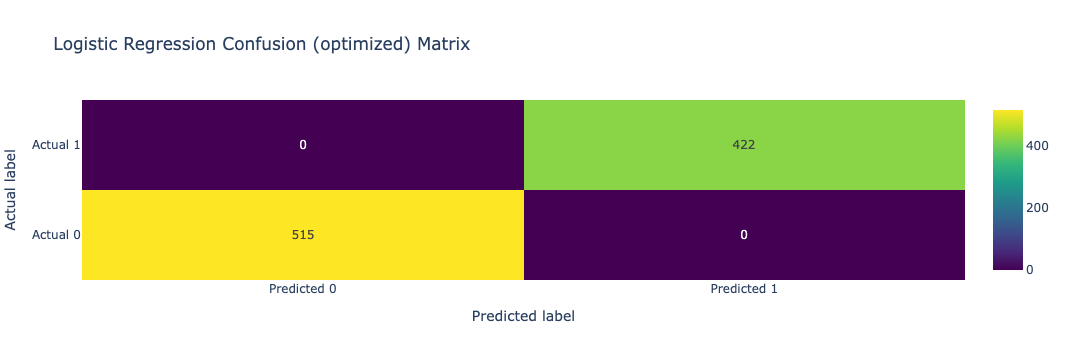

In [17]:
                                                                                
# Collect the true labels and predicted labels
y_true = cvPredictions.select("label").rdd.flatMap(lambda x: x).collect()
y_pred = cvPredictions.select("prediction").rdd.flatMap(lambda x: x).collect()
# For binary classification, collect the probability of the positive class for ROC
y_prob = cvPredictions.select("probability").rdd.map(lambda x: x[0][1]).collect()



                                                                                
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(y_true, y_pred)


import plotly.graph_objects as go
from sklearn.metrics import confusion_matrix, roc_curve, auc
import numpy as np
# Create the confusion matrix heatmap with annotations
fig_cm = go.Figure(data=go.Heatmap(
    z=conf_mat,
    x=["Predicted 0", "Predicted 1"],  
    y=["Actual 0", "Actual 1"],  
    showscale=True,
    colorscale='Viridis',
    text=conf_mat,
    texttemplate="%{text}",
    hoverinfo='none'  # Turns off hover info
))
fig_cm.update_layout(
    title='Logistic Regression Confusion (optimized) Matrix',
    xaxis=dict(title='Predicted label'),
    yaxis=dict(title='Actual label')
)
# Show the confusion matrix plot
fig_cm.show()

In [19]:
fig_cm.write_html("../../data/plots/title_classification_confusion_matrix(refined).html")

The cell for "Actual 0" and "Predicted 0" (bottom left) is yellow and has the highest count (515), indicating that there are 515 instances where the model correctly predicted class 0. This is known as the number of true negatives.

The cell for "Actual 1" and "Predicted 1" (top right) is green with a count of 422, indicating that there are 422 instances where the model correctly predicted class 1. This is the number of true positives.

The top left and bottom right cells are purple with a count of 0, indicating that there are no false negatives or false positives, respectively. This means the model did not make any incorrect predictions for the given dataset.

In summary, this confusion matrix indicates a perfect classifier on the given dataset, as there are no instances where the model made an incorrect prediction. However, this is highly unusual in practice and may suggest overfitting, an issue with the data, or that the results are being presented for a non-representative subset of the data. It's also possible that this could occur with a very simple or deterministic dataset.

The accuracy achieved by the logistic regression model in Spark MLlib, recorded at 99.6992%, indicates exceptional proficiency in classifying the given dataset. This measure of accuracy, a standard metric in classification problems, reflects the proportion of correct predictions made by the model in relation to the total number of predictions.

An accuracy of approximately 100% suggests that the model has extraordinary capability in accurately discerning and categorizing the data. This level of accuracy is particularly noteworthy and implies that the model can reliably be used for predictive purposes in scenarios similar to the training and testing environments.

However, several critical considerations must be taken into account:

Overfitting Risk: Exceptionally high accuracy might raise concerns about the model's overfitting, meaning it could be excessively tailored to the training data, potentially compromising its ability to generalize to new, unseen data.

Dataset Nuances: The characteristics of the dataset, such as its balance (or imbalance) among classes, size, and diversity, significantly influence the model's performance.

Generalizability: While high accuracy is desirable, it is crucial to evaluate whether the model can maintain this performance level on entirely new and diverse datasets, ensuring its applicability in real-world conditions.

Comprehensive Evaluation: Besides accuracy, other metrics like precision, recall, and the F1 score can provide a more holistic view of the model's performance, particularly in scenarios where class imbalance is present.

In summary, the achieved accuracy level is indicative of the logistic regression model's high effectiveness in the context of the specific dataset and the parameters chosen during the tuning process. However, further tests and validations are recommended to ensure its robustness and applicability to broader and more diverse datasets.

In [20]:
# Extract the best model from the Cross Validator
bestModel = cvModel.bestModel

# Save the best model, overwriting if the path already exists
bestModel.write().overwrite().save("./best_logistic_regression_model")
